In [1]:
using GLM, PyPlot, Printf, DataFrames, Dates

In [2]:
include("decode.jl")
include("utils.jl")
include("updateRule.jl")
include("readData.jl");

In [3]:
function computeShannonSurprise(rule, x_t, col)
    theta = rule.computeTheta(col)
    theta = x_t == 1 ? theta : 1 - theta
    return -log(theta) / log(2.0)
end

function decodeShannonSurprise(seq, m, alpha_0, rule, ignoreFirstM = true)
    # define callback to compute Shannon surprises
    callback = Callback(computeShannonSurprise, Float64)

    # decode sequence
    surprises = decode(seq, m, alpha_0, rule;
                       callback = callback, ignoreFirstM = ignoreFirstM)
    
    if ignoreFirstM && m > 0
        surprises[1:m] .= -log(0.5) / log(2.0)
    end
    
    return surprises
end;

In [4]:
function plotMEG(x, y, params)
    scatter(x, y, alpha=0.7, label=@sprintf("block = %i", params["block"]))
    
    title(@sprintf("%s using update rule %s, m = %i", params["title"], params["rule"], params["m"]))
    xlabel("Surprise (bits)")
    ylabel("MEG activity (pT)")
    
    grid("on")
    legend()
end;

In [5]:
function regression(subject, sensor, time, rule, m, alpha_0)
    
    surprises = decodeShannonSurprise.(subject.seq, m, Ref(alpha_0), Ref(rule))
    surprises = map((s,i) -> s[i], surprises, subject.seqIdx)
    
    megs = map(m -> m[:,sensor,time], subject.meg)
    
    # calc regression
    surprises1d = reduce(vcat, surprises)
    megs1d = reduce(vcat, megs)

    data = DataFrame(X=surprises1d, Y=megs1d)
    ols = lm(@formula(Y ~ 1 + X), data)
        
    return surprises, megs, ols
end;

In [61]:
# load subject data
sub = loadSubjectData(getFilename(13));
# sub2 = loadSubjectData(getFilename(2));

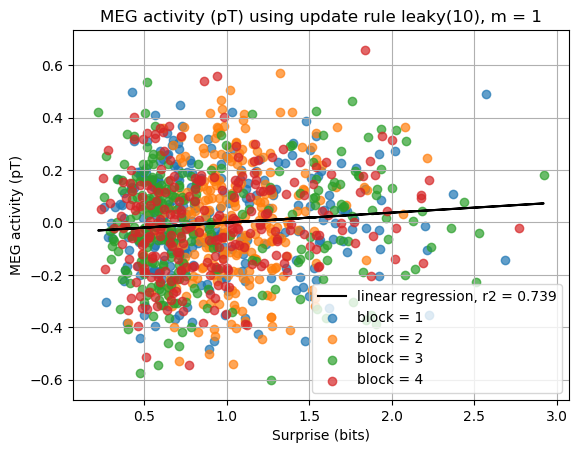

In [82]:
m = 1
rule = leaky(10)
ruleName = "leaky(10)"

# define initial params
alpha_0 = ones(2, 2^m)

# define which data we look at
subject = sub
sensor = 37 # in range [1, 306]
time = 120 # in range [1, 321]

surprises, megs, ols = regression(subject, sensor, time, rule, m, alpha_0)

@inbounds for i in eachindex(surprises)    
    # plot surprises
    infos = Dict(
        "title"   => "MEG activity (pT)", 
        "m"       => m,
        "sensor"  => sensor,
        "rule"    => ruleName,
        "block"   => i
    )
    
    plotMEG(surprises[i], megs[i], infos)
end

r2val = @sprintf("%.3f", 100 * r2(ols))
plot(reduce(vcat, surprises), predict(ols), "k", label="linear regression, r2 = $r2val")
legend()
;

In [57]:
function exportMaxR2(seq, filename)
    f = open("ckpt/$filename", "w")

    for el in seq
        print(f, el)
        print(f, " ")
    end
    
    close(f)
end

function importMaxR2(filename)
    f = open("ckpt/$filename", "r")
    t = readdlm(f)
    close(f)
    
    return t[1,1:321]
end;

function lg(x...)
    println("[", now(), "] ", join(x, " ")...)
    flush(stdout)
end
;

In [91]:
function maxR2(subject, rules, m, alpha_0, subjectIdx = 1)
    # get shannon surprises
    surprises = Array{Array{Float64,1},1}(undef, length(rules))
    @inbounds for i in eachindex(rules)
        # decode surprise values by block
        values = decodeShannonSurprise.(subject.seq, m, Ref(alpha_0), Ref(rules[i]))
        # reduce to 1d array
        surprises[i] = reduce(vcat, map((s,idx) -> s[idx], values, subject.seqIdx))
    end
    
    # get MEG values
    megs = reduce(vcat, subject.meg)
    
    # function that computes R2 of fit
    function getR2(x, y)
        return r2(lm(@formula(Y ~ X), DataFrame(X=x, Y=y)))
    end
    
    # get r2 for every model and sensor
    r2s = map(x -> map(y -> getR2(x, y), Slices(megs, 1)), surprises)
    r2s = twoDimArrayToMatrix(r2s)
    
    # max for each sensor
    r2s = @pipe findmax(r2s, dims=1) |> dropdims(_[1], dims=1)
    
    maxR2 = findmax(r2s)[1]
    @show(maxR2)
    
    # average across sensors
    r2s = @pipe mean(r2s, dims=1) |> dropdims(_, dims=1)
    
    # save in ckpt folder
    exportMaxR2(r2s, "max_r2_subject_$subjectIdx.txt")
    
    return r2s;
end;

In [92]:
function maxR2AcrossSubjects(subjects, rules, m, alpha_0)
    nTimesteps = 321
    maxR2List= zeros(length(subjects), nTimesteps)
    t = zeros(nTimesteps)
    
    @inbounds for subject in subjects
        lg("Processing subject $subject")
        
        # load subject
        sub = loadSubjectData(getFilename(subject))
        
        if subject == 1
            t = sub.time
        end
        
        # compute r2 timecourse
        maxR2List[subject,:] = maxR2(sub, rules, m, alpha_0, subject)
    end
    
    # average across subjects
    maxR2_ = @pipe mean(maxR2List, dims=1) |> dropdims(_, dims=1)
    
    # export data
    exportMaxR2(maxR2_, "max_r2.txt")
    
    return t, maxR2_, maxR2List
end
;

In [93]:
ws = [1, 4, 7, 10, 13, 16, 201, 260, 337]
rules = map(w -> leaky(w, true), ws)
rules = vcat(rules, perfect())
m = 1
alpha_0 = ones(2, 2^m)
subjects = 1:18

t, maxR2_, maxR2List = maxR2AcrossSubjects(subjects, rules, m, alpha_0);

[2020-04-05T23:26:32.219] Processing subject 1
maxR2 = 0.023700048367069404
[2020-04-05T23:31:51.475] Processing subject 2
maxR2 = 0.023823702568143812
[2020-04-05T23:36:55.413] Processing subject 3
maxR2 = 0.027917184881266266
[2020-04-05T23:42:00.127] Processing subject 4
maxR2 = 0.05654747739554655
[2020-04-05T23:46:28.946] Processing subject 5
maxR2 = 0.03863784660483527
[2020-04-05T23:50:55.527] Processing subject 6
maxR2 = 0.02512659925784111
[2020-04-05T23:55:31.169] Processing subject 7
maxR2 = 0.030702630147167564
[2020-04-06T00:00:00.655] Processing subject 8
maxR2 = 0.02062460913594555
[2020-04-06T00:04:24.915] Processing subject 9
maxR2 = 0.04534698060564202
[2020-04-06T00:08:28.139] Processing subject 10
maxR2 = 0.02806351897052428
[2020-04-06T00:11:03.43] Processing subject 11
maxR2 = 0.03180344550173886
[2020-04-06T00:13:00.367] Processing subject 12
maxR2 = 0.018646653689604387
[2020-04-06T00:15:02.001] Processing subject 13
maxR2 = 0.027754284680329255
[2020-04-06T00:1

In [88]:
r2s = zeros(321)
for subject in subjects
    r2s += importMaxR2("max_r2_subject_$subject.txt")
end

maxR2_ = r2s ./ length(subjects)
t = range(-250, stop = 1000, length = length(maxR2_)) |> collect
;

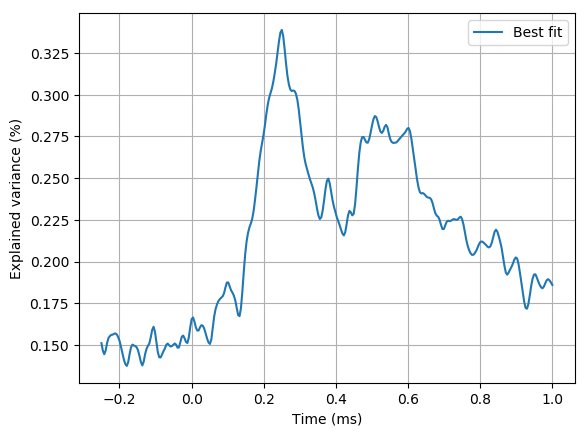

In [94]:
plot(t, 100 * maxR2_, label="Best fit")
xlabel("Time (ms)")
ylabel("Explained variance (%)")
grid("on")
legend()
;